<a href="https://colab.research.google.com/github/drscook/REU_2019/blob/master/REU_day_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Math/Psych REU Day 3 - Intro to Python 
### Tarleton State University
### Dr. Scott Cook

This notebook can also be run locally (say on the Anaconda Distribution https://www.anaconda.com/download/).  The google colab option is easiest because it does not require installation and can be used from any computer.

Resources
- https://realpython.com/
- Jake Vanderplas free books
    - Whirlwind Tour of Python - https://github.com/jakevdp/WhirlwindTourOfPython.git
    - Python Data Science Handbook - https://github.com/jakevdp/PythonDataScienceHandbook
    - Can access directly from Colab: File -> open notebook -> github -> paste link
- Google it

Today, I plan to cover more about Numpy using chapter 2 of https://github.com/jakevdp/PythonDataScienceHandbook.

Homework - Here is some code to get us started writing a simple simulation of the Sinai Billiard.  This will set things up and draw a picture.  Your job is to write code that finds the next collision point, move the particle there, and resolves the collisions.  For now, use the specular collision law.

To start, let's number the walls
- right = 0
- top = 1
- left = 2
- bottom = 3
- scatterer = 4

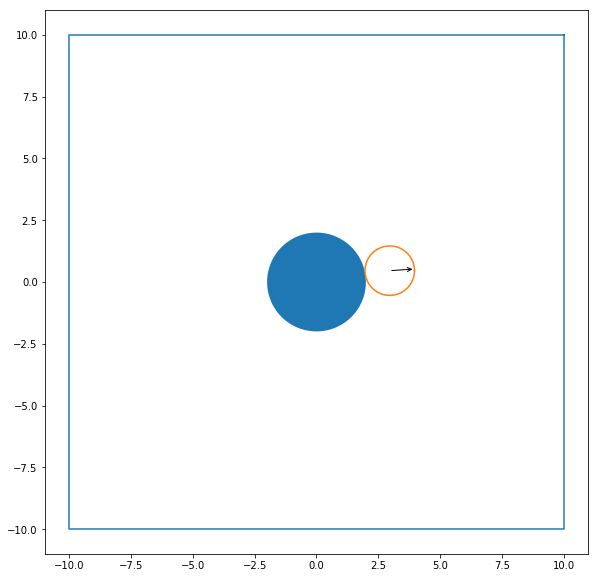

In [0]:
import numpy as np
import matplotlib.pyplot as plt

steps = 10
dim = 2
num_walls = 5

particle_radius = 1
side = 10  # This is HALF the length of a side, which will go from -side to +side
scatterer_radius = 2
assert (scatterer_radius < side), "scatterer won't fit in the box"  # checks that the scatterer fits inside the box



def initialize():
    # particle's initial position will be against the scatterer at angle theta to the positive x-axis
    theta = np.random.rand() * np.pi / 4  
    pos = np.array([np.cos(theta), np.sin(theta)]) * (particle_radius + scatterer_radius)


    # particle's initial velocity will be at angle phi to the normal vector at intial position
    a = np.random.rand()  # between 0 and 1
    a = 2*a - 1  # between -1 and +1
    phi =  a * np.pi / 2  #between -pi/2 and +pi/2


    # Now, we need to get a normal vector to the scatterer at intitial position.
    n = pos.copy()

    # But we want it to have length 1 (unit vector).
    n = n / np.linalg.norm(n)
   

    # Now, we want to rotate it by angle phi.  So, create the rotation matrix.
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]
                 ])

    # Apply it to n
    vel = R@n
    wall_idx = num_walls-1
    state = {'pos':pos, 'vel':vel, 'phi':phi, 'wall':wall_idx, 't':0}
    return state



def draw(state):
    pos = state['pos']
    vel = state['vel']
    fig, ax = plt.subplots(figsize=(10,10))

    # Trace box top-right, top-left, bottom-left, bottom-right, top-right
    s = side
    X = [s,-s,-s, s, s]
    Y = [s, s,-s,-s, s]
    box = ax.plot(X, Y)


    # Trace scatterer
    thetas = np.linspace(0, 2*np.pi, 100)
    U = np.array([np.cos(thetas), np.sin(thetas)])
    pts = U * scatterer_radius
    scatterer = ax.fill_between(pts[0], pts[1])


    # Trace particle
    thetas = np.linspace(0, 2*np.pi, 100)
    U = np.array([np.cos(thetas), np.sin(thetas)])
    pts = (U.T * particle_radius + pos).T
    particle = ax.plot(pts[0], pts[1])


    # Draw arrow for velocity
    ax.annotate("", xy=pos, xytext=pos+vel, arrowprops=dict(arrowstyle="<-"))

    ax.set_aspect('equal')
    plt.show()


state = initialize()
draw(state)

# Your job - Write the function "next_state"

The function "next_state" will evolve the system forward to the next collision event.
1. Find when the next collision occurs
1. Move the particle
1. Resolve the collision (determine the outgoing velocity)

## 1. Find when the next collision occurs
### 1a) Find time to collision with each wall
For each side of the box, imagine the wall keeps going and forms a line.  Find the time when the particle would hit this line.  The answer is
- positive if the particle is moving toward the line
- negative if the particle is moving away from the line
- zero if the particle is against the wall
Remember that pos is the *center* of the particle, which will not get all the way to the wall.  Record the answer in the entry of the array T corresponding that wall (we numbered the walls earlier).

It's trickier for the scatter.  Once it leaves a wall, the particle's position is given by $\vec{x}(t) = \vec{x}_0 + \vec{v}t$ where $t=0$ is the moment it leaves the prior collision.  The particle hits the scatterer when $||\vec{x}(t)||=R$, where R=particle radius + scatterer radius.  We square both sides to get $||\vec{x}(t)||^2=R^2$.  Recall from Calc 3 that $||\vec{x}(t)||^2 = \vec{x}(t) \cdot \vec{x}(t)$, the dot product of x with itself.  Thus, we wish to find $t$ such that:
$$
R^2 = \vec{x}(t) \cdot \vec{x}(t) = (\vec{x}_0 + \vec{v}t) \cdot (\vec{x}_0 + \vec{v}t) = \vec{x}_0 \cdot \vec{x}_0 + 2 \vec{x}_0 \cdot \vec{v} t + \vec{v} \cdot \vec{v} t^2\\R^2 = \vec{x}_0 \cdot \vec{x}_0 + 2 \vec{x}_0 \cdot \vec{v} t + \vec{v} \cdot \vec{v} t^2
$$

It we define 
$$a = \vec{v} \cdot \vec{v}\\b=2 \vec{x}_0 \cdot \vec{v}\\c=\vec{x}_0 \cdot \vec{x}_0-R^2$$
then the equation reads
$$0 = at^2 + bt + c$$

In other word, the $t$ we seek solves the quadratic with $a,b,c$ defined above.  Note there can be 2 solutions - keep the smallest positive one (if there are any).  If there aren't any, use np.nan.  Record in T[4].
### 1b) Find the smallest positive time
- Can't have negative time.  Replace any negative times in T by np.nan (recall fancy indexing idx = T < 0; T[idx]=np.nan).  
    - np.nan stands for "not a number".  It's a placeholder for missing data.  If you use np.min(A) on an array containing a nan, it will return nan.  However, if you use np.nanmin(A), it will ignore the nan's and return the min of the numeric entries.  Most numpy functions have a "nan-proof" version by simply sticking nan in front.  Exception: A.min() is equivalent to np.min(A).  But A.nanmin() won't work.  You have to use np.nanmin(A).
- Can't hit the same wall again.  Replace the entry in slot "prior_wall" by np.nan.  This is important - the particle can get stuck otherwise.
- Use np.nanargmin to find which *slot* holds the smallest time; call this next_wall.  Then our real $t$ is T[next_wall].

## 2. Move the particle
pos = pos + t*vel

prior_wall = next_wall.

## 3. Resolve the collision
If the particle hits a side, then the outgoing velocity is just in incoming velocity with one sign flipped.  Write code to implement this.

If is hits the scatterer, we must work harder.  Hopefully, Dr. Cox will justify the following expression for specular collisions in lecture.  Let $\hat{n}$ be the outward point unit (length 1) normal vecter to the scatterer at the collision point.  Then
$$\vec{v}_{out} = \vec{v}_{in} - 2 (\hat{n} \cdot \vec{v}_{in})\hat{n}$$

The circle is nice because the vector from the center of the scatterer to the center of the particle is automatically an outward point normal vector.  So $\vec{n} = pos$.  But you need to normalize it to length 1 before using it in the expression above.

#### Warning the code below has not been tested.  It can't run until you write next_state.  So, there could be little errors with my code.  Let me know if this happens.

In [0]:
def next_state(state_in):
    DT = np.full(shape=num_walls, fill_value=np.nan)  # initializes an array to hold collision times, prefilled with the "not a number" placeholder np.nan
    # Find collision times with each wall
    
    
    
    # Move particle
    
    # Resolve collision
    
    phi = vel@N # where N is the inward pointing unit normal vector at the collision
    
    
    return state_out


# Initialize arrays where the states will be recorded
state_history = {'POS':np.full(shape=(steps, dim), fill_value=np.nan), # steps x dim filled with the "not a number" placeholder np.nan
                 'VEL':np.full(shape=(steps, dim), fill_value=np.nan),
                 'WALL':np.full(shape=steps, fill_value=num_walls),
                 'PHI':np.full(shape=steps, fill_value=np.nan),
                 'T':np.full(shape=steps, fill_value=0.0),
                }

pos_history[0] = pos.copy()
vel_history[0] = vel.copy()
prior_wall_history = prior_wall

for i in range(steps):
    state_out = next_state(state_in)  # evolves the system forward one step
    
    ## record current state for later use
    state_history['POS'][i+1] = state['pos'].copy()
    state_history['VEL'][i+1] = state['vel'].copy()
    state_history['WALL'][i+1] = state['wall']
    state_history['PHI'][i+1] = state['phi']
    state_history['T'][i+1] = state['t']

Let's improve the old "draw" so that we can see the trails where the particle has been.

In [0]:
def draw(state):
    if state['POS'].ndim > 1:
        pos = state['POS'][-1]  # the last state position
        vel = state['VEL'][-1]  # the last state velocity
    else:  # if only given the last state, we can't draw the trails
        pos = state['POS']  # the last state position
        vel = state['VEL']  # the last state velocity
    
    fig, ax = plt.subplots(figsize=(10,10))

    # Trace box top-right, top-left, bottom-left, bottom-right, top-right
    s = side
    X = [s,-s,-s, s, s]
    Y = [s, s,-s,-s, s]
    box = ax.plot(X, Y)


    # Trace scatterer
    thetas = np.linspace(0, 2*np.pi)
    U = np.array([np.cos(thetas), np.sin(thetas)])
    pts = U * scatterer_radius
    scatterer = ax.fill_between(pts[0], pts[1])


    # Trace particle
    thetas = np.linspace(0, 2*np.pi)
    U = np.array([np.cos(thetas), np.sin(thetas)])
    pts = (U.T * particle_radius + pos).T
    particle = ax.plot(pts[0], pts[1])


    # Draw arrow for velocity
    ax.annotate("", xy=pos, xytext=pos+vel, arrowprops=dict(arrowstyle="<-"))
    
    
    # Draw trails
    if pos_hist.ndim > 1:
        ax.plot(pos_hist[:,0], pos_hist[:,1])

    ax.set_aspect('equal')
    plt.show()


draw(pos_hist, vel_hist)